<a href="https://colab.research.google.com/github/alisongx/regen-ag-UCB/blob/main/CA_Land_Use_by_County.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

# USDA Reports


In [61]:
us22 = pd.read_csv('/content/drive/MyDrive/junior/Regenerative Agriculture URAP/DATA/qs.census2022.txt', delimiter="\t")

In [62]:
ca22 = us22[us22['STATE_NAME'] == 'CALIFORNIA']
print(ca22.columns)
pd.set_option('display.max_columns', None)
ca22

Index(['SOURCE_DESC', 'SECTOR_DESC', 'GROUP_DESC', 'COMMODITY_DESC',
       'CLASS_DESC', 'PRODN_PRACTICE_DESC', 'UTIL_PRACTICE_DESC',
       'STATISTICCAT_DESC', 'UNIT_DESC', 'SHORT_DESC', 'DOMAIN_DESC',
       'DOMAINCAT_DESC', 'AGG_LEVEL_DESC', 'STATE_ANSI', 'STATE_FIPS_CODE',
       'STATE_ALPHA', 'STATE_NAME', 'ASD_CODE', 'ASD_DESC', 'COUNTY_ANSI',
       'COUNTY_CODE', 'COUNTY_NAME', 'REGION_DESC', 'ZIP_5', 'WATERSHED_CODE',
       'WATERSHED_DESC', 'CONGR_DISTRICT_CODE', 'COUNTRY_CODE', 'COUNTRY_NAME',
       'LOCATION_DESC', 'YEAR', 'FREQ_DESC', 'BEGIN_CODE', 'END_CODE',
       'REFERENCE_PERIOD_DESC', 'WEEK_ENDING', 'LOAD_TIME', 'VALUE', 'CV_%'],
      dtype='object')


,SOURCE_DESC,SECTOR_DESC,GROUP_DESC,COMMODITY_DESC,CLASS_DESC,PRODN_PRACTICE_DESC,UTIL_PRACTICE_DESC,STATISTICCAT_DESC,UNIT_DESC,SHORT_DESC,DOMAIN_DESC,DOMAINCAT_DESC,AGG_LEVEL_DESC,STATE_ANSI,STATE_FIPS_CODE,STATE_ALPHA,STATE_NAME,ASD_CODE,ASD_DESC,COUNTY_ANSI,COUNTY_CODE,COUNTY_NAME,REGION_DESC,ZIP_5,WATERSHED_CODE,WATERSHED_DESC,CONGR_DISTRICT_CODE,COUNTRY_CODE,COUNTRY_NAME,LOCATION_DESC,YEAR,FREQ_DESC,BEGIN_CODE,END_CODE,REFERENCE_PERIOD_DESC,WEEK_ENDING,LOAD_TIME,VALUE,CV_%
70,CENSUS,DEMOGRAPHICS,FARMS & LAND & ASSETS,FARM OPERATIONS,ALL CLASSES,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,OPERATIONS,OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,TENURE,TENURE: (PART OWNER),COUNTY,6.0,6,CA,CALIFORNIA,60.0,SIERRA MOUNTAINS,27.0,27.0,INYO,NaN,NaN,0,NaN,NaN,9000,UNITED STATES,"CALIFORNIA, SIERRA MOUNTAINS, INYO",2022,ANNUAL,0,0,YEAR,NaN,2024-02-13 12:00:00,7,14.0
78,CENSUS,CROPS,FIELD CROPS,HAYLAGE,(EXCL ALFALFA),ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,AREA HARVESTED,OPERATIONS,"HAYLAGE, (EXCL ALFALFA) - OPERATIONS WITH AREA...",TOTAL,NOT SPECIFIED,COUNTY,6.0,6,CA,CALIFORNIA,50.0,SACRAMENTO VALLEY,21.0,21.0,GLENN,NaN,NaN,0,NaN,NaN,9000,UNITED STATES,"CALIFORNIA, SACRAMENTO VALLEY, GLENN",2022,ANNUAL,0,0,YEAR,NaN,2024-02-13 12:00:00,35,(L)
164,CENSUS,CROPS,FRUIT & TREE NUTS,BOYSENBERRIES,ALL CLASSES,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,AREA BEARING,ACRES,BOYSENBERRIES - ACRES BEARING,TOTAL,NOT SPECIFIED,COUNTY,6.0,6,CA,CALIFORNIA,51.0,SAN JOAQUIN VALLEY,29.0,29.0,KERN,NaN,NaN,0,NaN,NaN,9000,UNITED STATES,"CALIFORNIA, SAN JOAQUIN VALLEY, KERN",2022,ANNUAL,0,0,YEAR,NaN,2024-02-13 12:00:00,(D),(D)
171,CENSUS,DEMOGRAPHICS,PRODUCERS,PRODUCERS,WHITE,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,PRODUCERS,PRODUCERS,"PRODUCERS, WHITE - NUMBER OF PRODUCERS",TOTAL,NOT SPECIFIED,COUNTY,6.0,6,CA,CALIFORNIA,80.0,SOUTHERN CALIFORNIA,83.0,83.0,SANTA BARBARA,NaN,NaN,0,NaN,NaN,9000,UNITED STATES,"CALIFORNIA, SOUTHERN CALIFORNIA, SANTA BARBARA",2022,ANNUAL,0,0,YEAR,NaN,2024-02-13 12:00:00,"2,667",8.0
193,CENSUS,ECONOMICS,FARMS & LAND & ASSETS,AG LAND,"CROPLAND, (EXCL HARVESTED & PASTURED), IDLE",ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,AREA,OPERATIONS,"AG LAND, CROPLAND, (EXCL HARVESTED & PASTURED)...",TOTAL,NOT SPECIFIED,COUNTY,6.0,6,CA,CALIFORNIA,10.0,NORTHERN COAST,23.0,23.0,HUMBOLDT,NaN,NaN,0,NaN,NaN,9000,UNITED STATES,"CALIFORNIA, NORTHERN COAST, HUMBOLDT",2022,ANNUAL,0,0,YEAR,NaN,2024-02-13 12:00:00,66,(L)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6076918,CENSUS,DEMOGRAPHICS,FIELD CROPS,CORN,ALL CLASSES,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,SALES,OPERATIONS,CORN - OPERATIONS WITH SALES,ORGANIZATION,"ORGANIZATION: (TAX PURPOSES, CORPORATION, FAMI...",STATE,6.0,6,CA,CALIFORNIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,9000,UNITED STATES,CALIFORNIA,2022,ANNUAL,0,0,YEAR,NaN,2024-02-13 12:00:00,171,11.2
6076969,CENSUS,ECONOMICS,INCOME,"INCOME, NET CASH FARM",OF PRODUCERS,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,LOSS,OPERATIONS,"INCOME, NET CASH FARM, OF PRODUCERS - OPERATIO...",TOTAL,NOT SPECIFIED,COUNTY,6.0,6,CA,CALIFORNIA,50.0,SACRAMENTO VALLEY,67.0,67.0,SACRAMENTO,NaN,NaN,0,NaN,NaN,9000,UNITED STATES,"CALIFORNIA, SACRAMENTO VALLEY, SACRAMENTO",2022,ANNUAL,0,0,YEAR,NaN,2024-02-13 12:00:00,741,(L)
6077038,CENSUS,ECONOMICS,EXPENSES,AG SERVICES,CUSTOMWORK,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,EXPENSE,OPERATIONS,"AG SERVICES, CUSTOMWORK - OPERATIONS WITH EXPENSE",EXPENSE,"EXPENSE: (1,000 TO 4,999 $)",STATE,6.0,6,CA,CALIFORNIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,9000,UNITED STATES,CALIFORNIA,2022,ANNUAL,0,0,YEAR,NaN,2024-02-13 12:00:00,"3,533",9.0
6077137,CENSUS,CROPS,FRUIT & TREE NUTS,PEARS,BARTLETT,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,AREA BEARING,ACRES,"PEARS, BARTLETT - ACRES BEARING",TOTAL,NOT SPECIFIED,COUNTY,6.0,6,CA,CALIFORNIA

In [63]:
def clean(df):
  df2 = df.copy()
  df2 = df2[df2['STATISTICCAT_DESC'] == 'AREA']
  df2 = df2[df2['UNIT_DESC'] == 'ACRES']
  df2 = df2[df2['COMMODITY_DESC'] == 'AG LAND']
  df2 = df2[['SECTOR_DESC', 'CLASS_DESC', 'PRODN_PRACTICE_DESC', 'AGG_LEVEL_DESC',
             'ASD_DESC', 'COUNTY_ANSI', 'COUNTY_NAME', 'VALUE']]
  return df2

ca22_clean = clean(ca22)

def group_county(df):
  df2 = df.copy()
  df2['VALUE'] = df2['VALUE'].replace('(D)', '0')
  df2['VALUE'] = df2['VALUE'].str.replace(',', '').astype(float).astype('Int64')
  df2 = df2.groupby(['COUNTY_NAME', 'CLASS_DESC']).agg({
    'VALUE': 'sum'
  })
  df2.reset_index(inplace=True)
  df2 = df2[
        (df2['CLASS_DESC'] == "(EXCL CROPLAND & PASTURELAND & WOODLAND)") |
        (df2['CLASS_DESC'] == "PASTURELAND, (EXCL CROPLAND & WOODLAND)") |
        (df2['CLASS_DESC'].isin(["CROPLAND", "WOODLAND"])) &
        ~df2['CLASS_DESC'].str.contains("EXCL", na=False)
    ]
  return df2

ca22_counties = group_county(ca22_clean)
total_farmland = ca22_counties.groupby('COUNTY_NAME').agg({'VALUE': 'sum'}).reset_index()

ca22_counties
total_farmland.head()

,COUNTY_NAME,VALUE
0,ALAMEDA,158500
1,ALPINE,0
2,AMADOR,132565
3,BUTTE,388383
4,CALAVERAS,221491


In [64]:
s = ca22[ca22['SHORT_DESC'] == 'FARM OPERATIONS - ACRES OPERATED']
s = s[s['DOMAIN_DESC'] == 'AREA OPERATED']

s['DOMAINCAT_DESC'].unique()
s

farm_size = {
    'county': ['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba'],
    'avg_farm_size': [399, 0, 298, 233, 367, 652, 516, 0, 77, 375, 447, 755, 1528, 4082, 1419, 688, 238, 1418, 90, 553, 478, 620, 695, 426, 1253, 1001, 1266, 137, 104, 238, 78, 627, 149, 230, 1010, 45, 44, 18, 251, 422, 180, 457, 297, 78, 255, 1336, 1027, 477, 151, 198, 290, 544, 411, 353, 392, 166, 602, 211]
}

farm_size = pd.DataFrame(farm_size)
farm_size.head()

,county,avg_farm_size
0,Alameda,399
1,Alpine,0
2,Amador,298
3,Butte,233
4,Calaveras,367


In [65]:
# FARM OPERATIONS, ORGANIC - NUMBER OF OPERATIONS by county
o = ca22[ca22['PRODN_PRACTICE_DESC'] == 'ORGANIC']
o = o[o['SHORT_DESC'] == 'FARM OPERATIONS, ORGANIC - NUMBER OF OPERATIONS']
o[o['COUNTY_NAME'] == 'ALAMEDA']
o['VALUE'] = o['VALUE'].str.replace(',', '').astype(float).astype('Int64')
o = o.groupby(['COUNTY_NAME']).agg({'VALUE':'sum'}) # FARM OPERATIONS, ORGANIC - NUMBER OF OPERATIONS
org_county = o.copy().reset_index()
org_county.head()

,COUNTY_NAME,VALUE
0,ALAMEDA,9
1,AMADOR,7
2,BUTTE,71
3,CALAVERAS,8
4,COLUSA,10


In [66]:
# orgp = ORGanic Potential
orgp = total_farmland.merge(org_county, on='COUNTY_NAME', how='left', suffixes=('_total', '_organic'))
orgp.rename(columns={'COUNTY_NAME':'county', 'VALUE_total': 'total_acres', 'VALUE_organic': 'curr_organic'}, inplace=True)
orgp['county'] = orgp['county'].str.title()
farm_size['county'] = farm_size['county'].str.title()
orgp = orgp.merge(farm_size, on='county', how='left')
orgp = orgp.fillna(0)

# adding ca row
california_totals = orgp.sum(numeric_only=True)
california_totals['county'] = 'California'
ca_totals = pd.DataFrame([california_totals])[['county'] + [col for col in california_totals.index if col != 'county']]
orgp = pd.concat([ca_totals, orgp], ignore_index=True)
orgp.loc[0, 'avg_farm_size'] = 383
orgp

# adding scenarios
orgp['curr_organic_acres'] = orgp['curr_organic'] * orgp['avg_farm_size']
# orgp['curr%'] = (orgp['curr_organic'] * orgp['avg_farm_size']) / orgp['total_acres'] * 100
orgp['10%_organic_scenario'] = orgp['total_acres'] * 0.1
orgp['50%_organic_scenario'] = orgp['total_acres'] * 0.5


orgp

,county,total_acres,curr_organic,avg_farm_size,curr_organic_acres,10%_organic_scenario,50%_organic_scenario
0,California,23597252,3374,383,1292242,2359725.2,11798626.0
1,Alameda,158500,9,399,3591,15850.0,79250.0
2,Alpine,0,0,0,0,0.0,0.0
3,Amador,132565,7,298,2086,13256.5,66282.5
4,Butte,388383,71,233,16543,38838.3,194191.5
5,Calaveras,221491,8,367,2936,22149.1,110745.5
6,Colusa,465843,10,652,6520,46584.3,232921.5
7,Contra Costa,68592,12,516,6192,6859.2,34296.0
8,Del Norte,13914,7,0,0,1391.4,6957.0
9,El Dorado,93239,36,77,2772,9323.9,46619.5


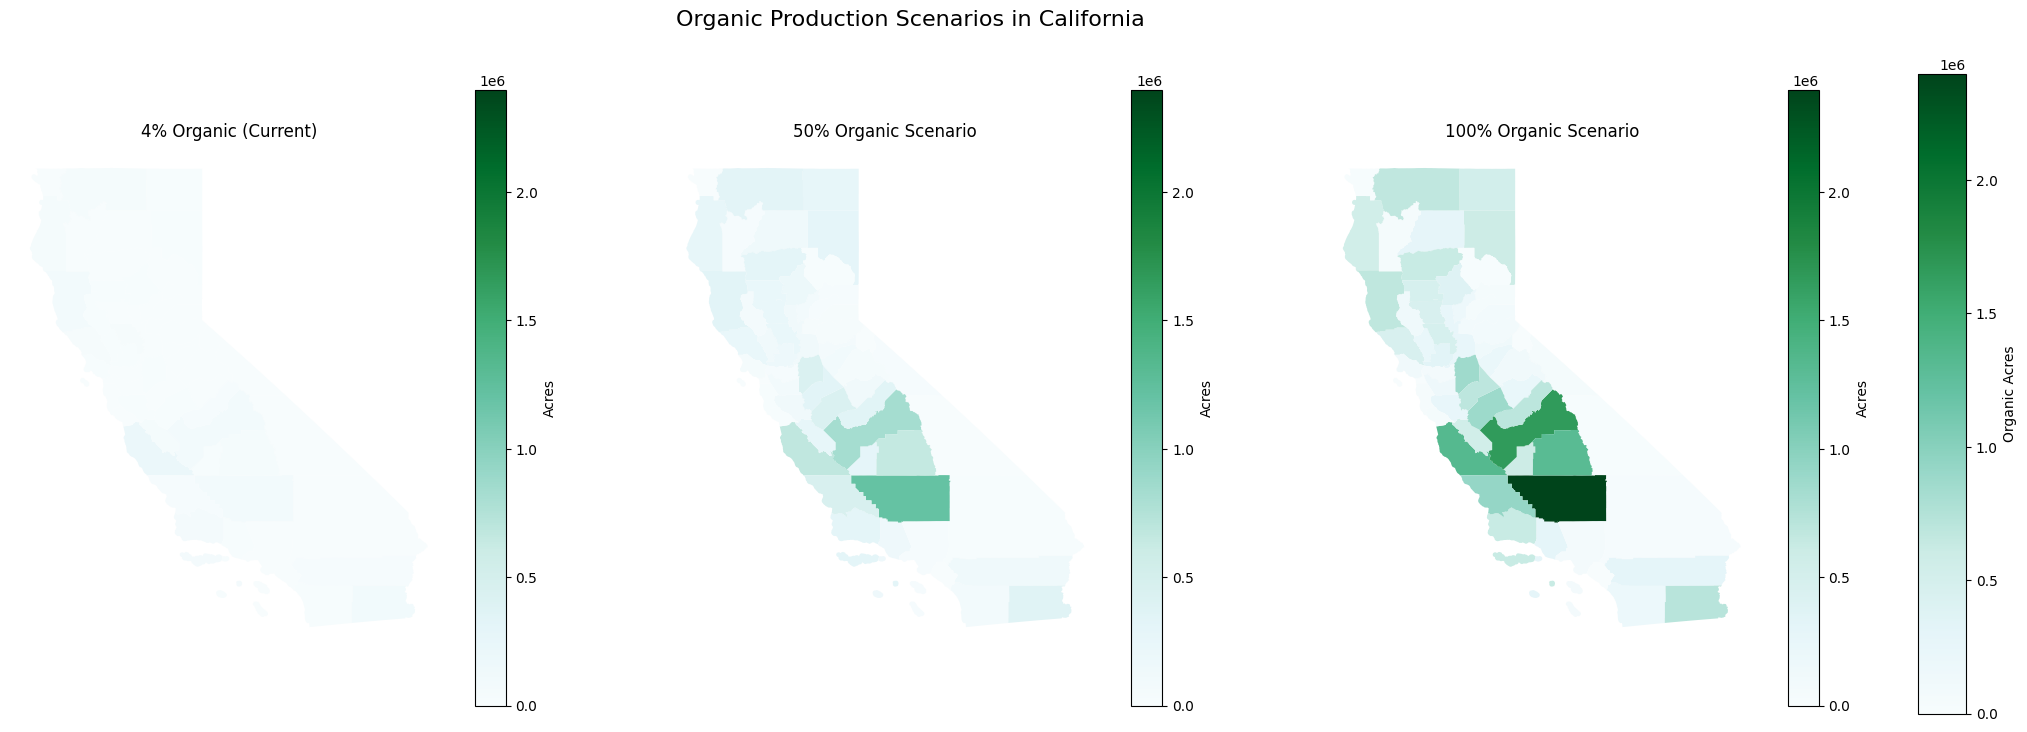

In [67]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

ca_counties = gpd.read_file('/content/drive/MyDrive/junior/Regenerative Agriculture URAP/DATA/ca_counties/CA_Counties.shp')
ca_counties = ca_counties.merge(orgp, left_on='NAME', right_on='county', how='left')

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Organic Production Scenarios in California', fontsize=16)

scenarios = {
    '4% Organic (Current)': 'curr_organic_acres',
    '50% Organic Scenario': '50%_organic_scenario',
    '100% Organic Scenario': 'total_acres'
}

vmin = 0.0  # Minimum value across all scenarios
vmax = 2399512.0  # Maximum value (total farmland)
norm = Normalize(vmin=vmin, vmax=vmax)

for i, (title, column) in enumerate(scenarios.items()):
    ax = axes[i]

    # Plot base map
    # ca_counties.plot(ax=ax, color='white', edgecolor='black')

    # Plot data with different opacity based on scenario
    ca_counties.plot(column=column,
                    ax=ax,
                    legend=True,
                    cmap='BuGn',
                    norm=norm,
                    legend_kwds={'label': 'Acres'})

    ax.set_title(title)
    ax.axis('off')

cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=norm)
fig.colorbar(sm, cax=cax, label='Organic Acres')

plt.show()

<ipython-input-68-691352f7cdf9>:16: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  ca_counties.plot(column='classification',


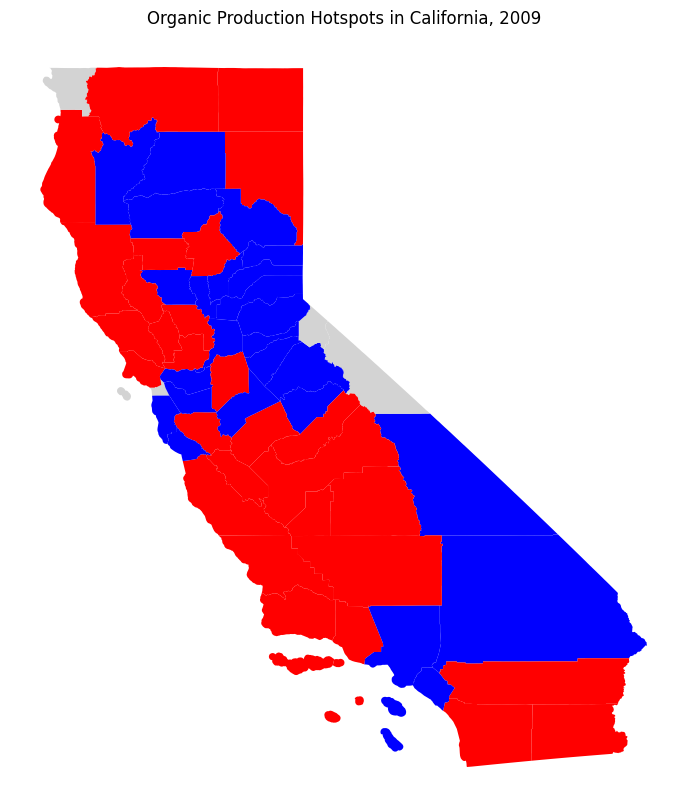

In [68]:
fig, ax = plt.subplots(figsize=(15, 10))

# Define the classification
def classify_county(acres):
    if acres > 10000:  # Adjust threshold as needed
        return 'Hotspot'
    elif acres > 0:
        return 'Coldspot'
    else:
        return 'Outlier'

# Create the map
ca_counties['classification'] = ca_counties['curr_organic_acres'].apply(classify_county)
colors = {'Hotspot': 'red', 'Coldspot': 'blue', 'Outlier': 'lightgray'}

ca_counties.plot(column='classification',
                ax=ax,
                legend=True,
                categorical=True,
                color=[colors[c] for c in ca_counties['classification']])

plt.title('Organic Production Hotspots in California, 2009')
plt.axis('off')
plt.show()


# Water Sequestration

In [71]:
def clean_org(df):
  df2 = df.copy()
  # df2 = df2[['SECTOR_DESC', 'CLASS_DESC', 'PRODN_PRACTICE_DESC', 'AGG_LEVEL_DESC',
  #            'ASD_DESC', 'COUNTY_ANSI', 'COUNTY_NAME', 'VALUE']]
  df2 = df2[df2['PRODN_PRACTICE_DESC'] == 'ORGANIC, TRANSITIONING']
  df2['VALUE'] = df2['VALUE'].astype(float).astype('Int64')

  return df2

ca22_org = clean_org(ca22)
ca22_org = ca22_org[['AGG_LEVEL_DESC', 'COUNTY_NAME', 'VALUE']]

cubic_meters_per_acre = 616.7
bulk_density = 1330  # kg/cubic meter
lbs_per_kg = 2.204623
organic_matter_water_multiplier = 10
lbs_per_gallon = 8.3454

def water_retention_curr(df2, total_farmland):
    df = df2.copy()
    df.rename(columns={'VALUE': 'Acres Transitioning'}, inplace=True)
    df['Cubic Meters of Soil'] = df['Acres Transitioning'] * cubic_meters_per_acre
    df['Kg of Soil'] = df['Cubic Meters of Soil'] * bulk_density
    df['Kg of 1% Organic Matter'] = df['Kg of Soil'] * 0.01
    df['Kg of Water Held'] = df['Kg of 1% Organic Matter'] * organic_matter_water_multiplier
    df['Gallons of Water Held'] = df['Kg of Water Held'] * lbs_per_kg / lbs_per_gallon

    # Calculate number of people supplied in one day using the state average
    df['Num People Supplied'] = (df['Gallons of Water Held'] / 61.9).round()

    if 'index' not in total_farmland.columns:
      total_farmland.reset_index(inplace=True)
    df = df.merge(total_farmland, how='left')

    tfl = df.pop('VALUE')
    df.insert(2, 'Total Farmland', tfl)
    df.loc[31, 'Total Farmland'] = 23597252
    # perc = ca22_org['Acres Transitioning'] / ca22_org['Total Farmland']
    # df.insert(4, 'Acres Transitioning %', perc)
    df.drop(columns=['index'], inplace=True)

    return df

ca22_water = water_retention_curr(ca22_org, total_farmland).sort_values('COUNTY_NAME')
ca22_water.head()

,AGG_LEVEL_DESC,COUNTY_NAME,Total Farmland,Acres Transitioning,Cubic Meters of Soil,Kg of Soil,Kg of 1% Organic Matter,Kg of Water Held,Gallons of Water Held,Num People Supplied
2,COUNTY,CALAVERAS,221491,2,1233.4,1640422.0,16404.22,164042.2,43335.395199,700.0
3,COUNTY,DEL NORTE,13914,1,616.7,820211.0,8202.11,82021.1,21667.697599,350.0
14,COUNTY,FRESNO,1659451,15,9250.5,12303165.0,123031.65,1230316.5,325015.46399,5251.0
30,COUNTY,GLENN,484172,5,3083.5,4101055.0,41010.55,410105.5,108338.487997,1750.0
5,COUNTY,HUMBOLDT,544630,7,4316.9,5741477.0,57414.77,574147.7,151673.883195,2450.0


In [72]:

orgp2 = orgp.drop(columns=['curr_organic', '10%_organic_scenario', 'avg_farm_size'])
orgp2.insert(3, '100%_organic_scenario', orgp2.pop('total_acres'))
orgp2

def calculate_water_retention(df, scenario_column):
    # Constants
    cubic_meters_per_acre = 4046.86
    bulk_density = 1300  # kg/m3
    organic_matter_water_multiplier = 20
    lbs_per_kg = 2.20462
    lbs_per_gallon = 8.34

    df = df.copy()

    df['Cubic Meters of Soil'] = df[scenario_column] * cubic_meters_per_acre
    df['Kg of Soil'] = df['Cubic Meters of Soil'] * bulk_density
    df['Kg of 1% Organic Matter'] = df['Kg of Soil'] * 0.01
    df['Kg of Water Held'] = df['Kg of 1% Organic Matter'] * organic_matter_water_multiplier
    df['Gallons of Water Held'] = df['Kg of Water Held'] * lbs_per_kg / lbs_per_gallon

    # Calculate number of people supplied in one day using the state average
    df['Num People Supplied'] = (df['Gallons of Water Held'] / 89).round()

    return df


# current_scenario = calculate_water_retention(orgp2, 'curr_organic_acres')
fifty_percent_scenario = calculate_water_retention(orgp2, '50%_organic_scenario')
fifty_percent_scenario['LA_supplied'] = fifty_percent_scenario['Num People Supplied'] / 9663000
fifty_percent_scenario.drop(columns=['curr_organic_acres', '100%_organic_scenario'], inplace=True)

hundred_percent_scenario = calculate_water_retention(orgp2, '100%_organic_scenario')
hundred_percent_scenario['LA_supplied'] = hundred_percent_scenario['Num People Supplied'] / 9663000
hundred_percent_scenario.drop(columns=['curr_organic_acres', '50%_organic_scenario'], inplace=True)



print('fifty_percent_scenario:')
display(fifty_percent_scenario[fifty_percent_scenario['county'] == 'Kern'])
print('hundred_percent_scenario:')
display(hundred_percent_scenario[hundred_percent_scenario['county'] == 'Kern'])

fifty_percent_scenario:


,county,50%_organic_scenario,Cubic Meters of Soil,Kg of Soil,Kg of 1% Organic Matter,Kg of Water Held,Gallons of Water Held,Num People Supplied,LA_supplied
15,Kern,1199756.0,4855244566.16,6311817936008.0,63118179360.080002,1262363587201.600098,333696883886.857483,3749403190.0,388.016474


hundred_percent_scenario:


,county,100%_organic_scenario,Cubic Meters of Soil,Kg of Soil,Kg of 1% Organic Matter,Kg of Water Held,Gallons of Water Held,Num People Supplied,LA_supplied
15,Kern,2399512,9710489132.32,12623635872016.0,126236358720.160004,2524727174403.200195,667393767773.714966,7498806379.0,776.032948


In [ ]:
ca22_counties.to_excel("ca22_land.xlsx",
             sheet_name='Land Use by County')
ca22_org
total_farmland

with pd.ExcelWriter('ca22_land.xlsx') as writer:
    total_farmland.to_excel(writer, sheet_name='Total Farmland')
    ca22_counties.to_excel(writer, sheet_name='Land Use by County')
    ca22_org.to_excel(writer, sheet_name='Counties Transitioning Organic')
    ca22_water.to_excel(writer, sheet_name='Water Retained from Transition')

# CNRA Data

In [ ]:
!pip install simpledbf pandas

  Preparing metadata (setup.py) ... done
  Created wheel for simpledbf: filename=simpledbf-0.2.6-py3-none-any.whl size=13785 sha256=fff28bf55bab102432435581eefb6efe03f894faec439227df81d1815846de7b
  Stored in directory: /root/.cache/pip/wheels/e5/41/13/ebdef29165b9309ec4e235dbff19eca8b6759125b0924ad430
Successfully built simpledbf


In [ ]:
import geopandas as gpd
from simpledbf import Dbf5

dbf22 = Dbf5('/content/drive/MyDrive/junior/Regenerative Agriculture URAP/DATA/i15_Crop_Mapping_2022_Provisional_shp/[DBF] i15_Crop_Mapping_2022_Provisional.dbf')
df22 = dbf22.to_dataframe()

dbf21 = Dbf5('/content/drive/MyDrive/junior/Regenerative Agriculture URAP/DATA/i15_Crop_Mapping_2021_SHP/i15_Crop_Mapping_2021.dbf')
df21 = dbf21.to_dataframe()

**SYMB_CLASS** <br> Derived from CLASS2, with spaces and asterisks removed. It represents the primary land use or crop type.

**MULTIUSE** <br> Indicates sequential or concurrent land uses within a polygon.
<br> <br>

<table> <tr> <th colspan="2">SYMB_CLASS</th> <th colspan="2">MULTIUSE</th> </tr> <tr> <td>P</td> <td>Pasture</td> <td>S</td> <td>Single land use or crop</td> </tr> <tr> <td>V</td> <td>Vineyards</td> <td>D</td> <td>Double cropped (two crops grown in sequence)</td> </tr> <tr> <td>G</td> <td>Grain and hay crops</td> <td>T</td> <td>Triple cropped (three crops grown in sequence)</td> </tr> <tr> <td>I</td> <td>Idle</td> <td>Q</td> <td>Quadruple cropped (four crops grown in sequence)</td> </tr> <tr> <td>T</td> <td>Truck, nursery, and berry crops</td> <td>I*</td> <td>Intercropped (e.g., orchards with annual crops between rows)</td> </tr> <tr> <td>C</td> <td>Citrus and subtropical</td> <td>M*</td> <td>Mixed use (mixture of two or three land uses in one area)</td> </tr> <tr> <td>YP</td> <td>Young Perennial</td> <td colspan="2"></td> </tr> <tr> <td>X</td> <td>Unclassified fallow</td> <td colspan="2"></td> </tr> <tr> <td>D</td> <td>Deciduous fruits and nuts</td> <td colspan="2"></td> </tr> <tr> <td>F</td> <td>Field crops</td> <td colspan="2"></td> </tr> <tr> <td>R</td> <td>Rice</td> <td colspan="2"></td> </tr> <tr> <td>UL</td> <td>Urban Lawn (irrigated areas like golf courses, cemeteries)</td> <td colspan="2"></td> </tr> <tr> <td>U</td> <td>Urban (unsegregated)</td> <td colspan="2"></td> </tr> </table> <p>* Not present in data but part of the full classification</p> <p>Note: Percentages for each use are stored in PCNT1, PCNT2, PCNT3, and PCNT4 fields.</p>

In [ ]:
ca22 = df22.copy()
ca21 = df22.copy()

print(df21.columns)

df22.head()
df21.head()

Index(['DataStatus', 'UniqueID', 'DWR_REVISE', 'SYMB_CLASS', 'MULTIUSE',
       'CLASS1', 'SUBCLASS1', 'SPECOND1', 'IRR_TYP1PA', 'IRR_TYP1PB', 'PCNT1',
       'CLASS2', 'SUBCLASS2', 'SPECOND2', 'IRR_TYP2PA', 'IRR_TYP2PB', 'PCNT2',
       'CLASS3', 'SUBCLASS3', 'SPECOND3', 'IRR_TYP3PA', 'IRR_TYP3PB', 'PCNT3',
       'CLASS4', 'SUBCLASS4', 'SPECOND4', 'IRR_TYP4PA', 'IRR_TYP4PB', 'PCNT4',
       'UCF_ATT', 'YR_PLANTED', 'SEN_CROP', 'ADOY_SEN', 'CROPTYP1',
       'CTYP1_NOTE', 'ADOY1', 'CROPTYP2', 'CTYP2_NOTE', 'ADOY2', 'CROPTYP3',
       'CTYP3_NOTE', 'ADOY3', 'CROPTYP4', 'CTYP4_NOTE', 'ADOY4', 'EMRG_CROP',
       'ADOY_EMRG', 'REGION', 'ACRES', 'COUNTY', 'HYDRO_RGN', 'LIQ_REPORT',
       'MAIN_CROP', 'MAIN_CROP_', 'Shape_Leng', 'Shape_Area'],
      dtype='object')


,DataStatus,UniqueID,DWR_REVISE,SYMB_CLASS,MULTIUSE,CLASS1,SUBCLASS1,SPECOND1,IRR_TYP1PA,IRR_TYP1PB,...,ADOY_EMRG,REGION,ACRES,COUNTY,HYDRO_RGN,LIQ_REPORT,MAIN_CROP,MAIN_CROP_,Shape_Leng,Shape_Area
0,Final,3200104,NaN,X,S,**,**,*,*,*,...,0.0,NRO,128.586349,Plumas,Sacramento River,X **** **** ****,X,0.0,0.026629,0.000055
1,Final,3200103,NaN,I,S,**,**,*,*,*,...,0.0,NRO,20.345581,Plumas,Sacramento River,I1 **** **** ****,I1,0.0,0.013783,0.000009
2,Final,3200101,NaN,P,S,**,**,*,*,*,...,0.0,NRO,35.763350,Plumas,Sacramento River,P4 **** **** ****,P4,0.0,0.018810,0.000015
3,Final,3200099,r,P,S,**,**,*,*,*,...,0.0,NRO,16.543104,Plumas,Sacramento River,P3 **** **** ****,P4,0.0,0.010619,0.000007
4,Final,3200098,NaN,T,S,**,**,*,*,*,...,0.0,NRO,19.805062,Plumas,Sacramento River,T16 **** **** ****,T16,0.0,0.011585,0.000008


In [ ]:
def clean_drop(df):
  df2 = df.copy()
  column_keep = [
      'UniqueID', 'SYMB_CLASS', 'MULTIUSE',
      'CLASS1', 'SUBCLASS1',
      'IRR_TYP1PA', 'PCNT1', 'YR_PLANTED',
      'REGION', 'ACRES', 'COUNTY',
      'HYDRO_RGN', 'MAIN_CROP'

  ]
  df2 = df2[column_keep]
  return df2

ca22_clean = clean_drop(ca22)
ca21_clean = clean_drop(ca21)

print(ca22_clean['ACRES'].sum())

14617448.149651539


In [ ]:
def clean_group (df):
  df2 = df.copy()
  df2.groupby('COUNTY').agg({
    'SYMB_CLASS': 'max',
    'MULTIUSE': 'max',
    'REGION': 'max',
    'ACRES': 'sum',
    'HYDRO_RGN': lambda x: list(set(x)),
    'MAIN_CROP': 'max'
})
  return df2

ca22_final = clean_group(ca22_clean)
ca21_final = clean_group(ca21_clean)

In [ ]:
def is_only_asterisks(column):
    return column.apply(lambda x: set(x) == {'*'}).all()

ca22[ca22['COUNTY'] == 'Santa Clara']
ca21[ca21['SYMB_CLASS'] == 'UC']
# ca22.columns
is_only_asterisks(ca22['SUBCLASS1'])
ca21[ca21['EMRG_CROP'] != '*']

NameError: name 'ca22' is not defined

In [ ]:
# Drop unrelated columns
caland = df.copy()
columns_to_drop = [
    'DataStatus', 'UniqueID', 'DWR_REVISE', 'SYMB_CLASS', 'MULTIUSE',
    'CLASS1', 'SUBCLASS1', 'SPECOND1', 'IRR_TYP1PA', 'IRR_TYP1PB', 'PCNT1',
    'CLASS2', 'SUBCLASS2', 'SPECOND2', 'IRR_TYP2PA', 'IRR_TYP2PB', 'PCNT2',
    'CLASS3', 'SUBCLASS3', 'SPECOND3', 'IRR_TYP3PA', 'IRR_TYP3PB', 'PCNT3',
    'CLASS4', 'SUBCLASS4', 'SPECOND4', 'IRR_TYP4PA', 'IRR_TYP4PB', 'PCNT4',
    'UCF_ATT', 'YR_PLANTED', 'SEN_CROP', 'ADOY_SEN', 'CROPTYP1', 'ADOY1',
    'CROPTYP2', 'ADOY2', 'CROPTYP3', 'ADOY3', 'CROPTYP4', 'ADOY4',
    'EMRG_CROP', 'ADOY_EMRG', 'LIQ_REPORT', 'WO1_FREQUE'
]
caland.drop(columns=columns_to_drop, inplace=True)

KeyError: "['DataStatus', 'UniqueID', 'DWR_REVISE', 'SYMB_CLASS', 'MULTIUSE', 'CLASS1', 'SUBCLASS1', 'SPECOND1', 'IRR_TYP1PA', 'IRR_TYP1PB', 'PCNT1', 'CLASS2', 'SUBCLASS2', 'SPECOND2', 'IRR_TYP2PA', 'IRR_TYP2PB', 'PCNT2', 'CLASS3', 'SUBCLASS3', 'SPECOND3', 'IRR_TYP3PA', 'IRR_TYP3PB', 'PCNT3', 'CLASS4', 'SUBCLASS4', 'SPECOND4', 'IRR_TYP4PA', 'IRR_TYP4PB', 'PCNT4', 'UCF_ATT', 'YR_PLANTED', 'SEN_CROP', 'ADOY_SEN', 'CROPTYP1', 'ADOY1', 'CROPTYP2', 'ADOY2', 'CROPTYP3', 'ADOY3', 'CROPTYP4', 'ADOY4', 'EMRG_CROP', 'ADOY_EMRG', 'LIQ_REPORT', 'WO1_FREQUE'] not found in axis"

In [ ]:
caland[caland['COUNTY'] == 'Santa Clara']

NameError: name 'caland' is not defined